In [4]:
using BlackBoxOptim, NLsolve, Distributions, QuadGK, Plots, LaTeXStrings, LeastSquaresOptim, Roots

In [2]:
eqf(xi, w, t) = (1 - Fv(xi)) * phi(w) - t * (1 - Fv(t))
phi(x) = x - (1 - Fv(x))/fv(x)

phi (generic function with 1 method)

Calculate unconstrained auction: As in the first part. 

In [3]:
function unconstrained_auc(alpha, Fval, n)
    xi = [i for i = 0:0.1:1]
    Fv(x) = cdf(Fval, x)
    fv(x) = pdf(Fval,x)
    function pi(x)
        return  (1 - Fv(x[1])) * x[1]
    end
    #create a negative replica since the optimizer is finding the minimum. 
    pin(x) = -pi(x)
    res = bboptimize(pin ; SearchRange = (0.0 , 1.0), NumDimensions = 1);
    r_star = best_candidate(res)[1]
    
    values = []
    for xi in filter(x -> x>r_star, [i for i = 0:0.01:1])
        t = max(xi, r_star)
        eqf(xi, w, t) = (1 - Fv(xi)) * phi(w) - t * (1 - Fv(t))
        phi(x) = x - (1 - Fv(x))/fv(x)
        eqf_a(w) = eqf(xi, w, t)
        w_hat = fzero(eqf_a,0,0.999)
        #calculate lhs
        Q_eps(alpha, w, xi, n) = ((1 - alpha)*Fv(w) + alpha * Fv(xi))^(n-1)
        Q_eps_a(w) = Q_eps(alpha, w, xi, n)
        l_value = quadgk(Q_eps_a, r_star, w_hat)[1]
        #calculate rhs
        t_adc = max(xi, r_star)
        Qeps2(xi,w,alpha)=(((1-alpha)*Fv(w)+alpha)^n - ((1-alpha)*Fv(w)+ alpha*Fv(xi))^n)/(alpha * (1-Fv(xi)))
        r_value = Qeps2(xi,w_hat,alpha)*max(w_hat - t_adc)
        push!(values, [r_star, xi, w_hat, l_value, r_value])
    end
    return(values)
end
#we can confirm this works ok now

unconstrained_auc (generic function with 1 method)

In [5]:
unconstrained_auc(0.8, Uniform(0,1) ,3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.09 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 113333.53
Function evals per second = 114489.42
Improvements/step = 0.64490
Total function evaluations = 10103


Best candidate found: [0.5]

Fitness: -0.250000000



50-element Vector{Any}:
 [0.5000000006365414, 0.51, 0.755, 0.07263394483573159, 0.42838029500000013]
 [0.5000000006365414, 0.52, 0.76, 0.07643722649718371, 0.4247193599999999]
 [0.5000000006365414, 0.53, 0.765, 0.08037034815855436, 0.42088946500000013]
 [0.5000000006365414, 0.54, 0.77, 0.08443547981984352, 0.4168878799999998]
 [0.5000000006365414, 0.55, 0.775, 0.0886347914810512, 0.4127118750000001]
 [0.5000000006365414, 0.56, 0.78, 0.09297045314217742, 0.40835871999999984]
 [0.5000000006365414, 0.57, 0.785, 0.09744463480322213, 0.40382568500000016]
 [0.5000000006365414, 0.58, 0.79, 0.10205950646418539, 0.39911004000000005]
 [0.5000000006365414, 0.59, 0.795, 0.10681723812506717, 0.39420905500000025]
 [0.5000000006365414, 0.6, 0.7999999999999999, 0.11171999978586744, 0.38911999999999985]
 [0.5000000006365414, 0.61, 0.8049999999999999, 0.11676996144658626, 0.38384014499999985]
 [0.5000000006365414, 0.62, 0.81, 0.12196929310722365, 0.3783667600000001]
 [0.5000000006365414, 0.63, 0.8150000

In [5]:
v_3 = [i for i = unconstrained_auc(0.8, Truncated(Chi(0.5),0,1),3)]
v_lhs3 = [i[4] for i in v_3]
v_rhs3 = [i[5] for i in v_3]

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.01 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 1242071.37
Function evals per second = 1181588.54
Improvements/step = 0.21940
Total function evaluations = 9514


Best candidate found: [0.397915]

Fitness: -0.127079071



61-element Vector{Float64}:
   0.5727917927724453
   0.5693829407873319
   0.5657367429870646
   0.5618551801299095
   0.5577401599951503
   0.553393524330733
   0.5488170551129589
   0.5440124801977841
   0.5389814784324908
   0.5337256842872772
   0.5282466920585931
   0.5225460596893778
   0.5166253122457473
   ⋮
   0.15527773673349216
   0.14198658533357938
   0.12852656475358834
   0.11489896255167714
   0.10110506730223315
   0.08714616850207577
   0.0730235564640637
   0.05873852219892693
   0.04429235728618434
   0.02968635373489498
   0.01492180383500417
 NaN

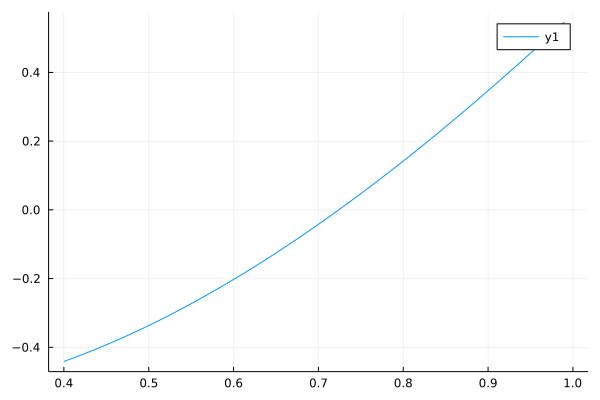

In [6]:
plot([i[2] for i in v_3], v_lhs3 .- v_rhs3)

In [6]:
function zeros(domain,value)
    if length(domain) != length(value)
        error("domain length must match value length")
    end
    zeros = []
    for i in 1:length(domain)-1
        if (value[i] < 0 && value[i+1] > 0) |((value[i] > 0 && value[i+1] < 0)) #methods of bisection, might be able to improve accuracy by further nesting iterations 
            zero = push!(zeros,(domain[i] + domain[i+1])/2)
        #implement checks if values is just zero
        elseif (value[i] == 0) | (value[i+1] == 0)
            if value[i] == 0
                zero = push!(zeros, domain[i])
            else
                zero = push!(zeros, domain[i+1])
            end
        else
            continue
        end
    end
    return(zeros)
end

zeros (generic function with 1 method)

In [8]:
zeros([i[2] for i in v_3], v_lhs3 .- v_rhs3)

1-element Vector{Any}:
 0.725

In [50]:
using LeastSquaresOptim
function optimum_auc(alpha, F_val, n)

    F(x) = cdf(F_val, x)
    f(x) = pdf(F_val, x)
    
    #2. solve for rstar, xi2
    unconstrained = unconstrained_auc(alpha, F_val,n)
    unconstrained_lhs = [i[4] for i in unconstrained]
    unconstrained_rhs = [i[5] for i in unconstrained]
    r_star = unconstrained[1][1]
    xi2 = zeros([i[2] for i in unconstrained], unconstrained_lhs .- unconstrained_rhs)[1] #since lhs - rhs is single crossing, we would need 
    
    OptimAucs0 = [[i[2],max(i[1],i[2]),i[3]] for i in unconstrained]
    
    
    #3. solve for xi1
    function max_return(f,set)
        optimum_auc = []
        maximum_rev = maximum([f(set[i]) for i = 1:maximum(size(set))])
        for i in 1:maximum(size(set))
            if f(set[i]) == maximum_rev
                push!(optimum_auc, set[i])
            end
        end
        return(optimum_auc, maximum_rev)
    end
    makes_sense(b) = (0 < b[1] <= b[2] <= b[3] <= b[4]) # && (b[1] > r_star) && (b[2] > r_star) && (b[3] > r_star) && (b[4] )
    grid_initial_raw = [[i;j;k;l] for i = 0:0.1:1 for j = 0:0.1:1 for k = 0:0.1:1 for l = 0:0.1:1]
    grid_initial = filter((x) -> makes_sense(x),grid_initial_raw)

    OptimAucs = []
    #for xi,best auc pairs. Aucs are calculated like in lemma 4, and we find xi2 when xi = t*. 
    for xi in filter(x -> (x > r_star) && (x < xi2), [i for i = 0:0.01:0.99])
        #optim auctions for given xi
        OptimAuc = []
        #the needed equations, we put it inside the loop as they changes with xi
        phi(x) = x - (1 - F(x))/f(x)
        eq1_new(alpha,xi,t,v_min, v_max) = alpha * (t*(1-F(t))-(1-F(xi))*phi(v_max)) - (1-alpha)*((v_min-t)*((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))* f(v_min) + (F(v_max)-F(v_min))*((v_max - (1-F(v_max))/f(v_max))-((1-F(v_min))*v_min-(1-F(v_max))*v_max)))
        phidiff(v_max,v_min) = ((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))
        Fp(s)= F(s)^(n-1)
        eq2(alpha, t, v_min, v_max) = -alpha*(-f(t)*t+(1-F(t))) - (1-alpha)*phidiff(v_max,v_min)*f(v_min)
        Q_eps(alpha, w, xi, n) = ((1 - alpha)*F(w) + alpha * F(xi))^(n-1)
        Qeps2(xi,v_min,v_max,alpha)=(((1-alpha)*F(v_max)+alpha)^n -((1-alpha)*F(v_min)+ alpha*F(xi))^n)/(n*(((1-alpha)*(F(v_max)-F(v_min))) + alpha * (1-F(xi))))
        eq3(r,v_min,v_max)= -(r - (1-F(r))/f(r))*f(r) - phidiff(v_max,v_min)*f(v_min)
        Q_eps_a(w) = Q_eps(alpha, w, xi, n)
        eq4_new(alpha,xi,r,t,v_min,v_max) = quadgk(Q_eps_a, r_star, v_min)[1] - Qeps2(xi,v_min,v_max,alpha) * max(v_min - t, 0)
        adheqvec(alpha,xi, r, t, v_min, v_max) = [eq1_new(alpha, xi, t, v_min, v_max)  eq2(alpha, t, v_min, v_max) eq3(r,v_min,v_max) eq4_new(alpha, xi, r, t, v_min, v_max)]
        adeqvec(x) = adheqvec(alpha,xi,x[1],x[2],x[3],x[4])
        
        for i in filter(x -> (x[1] != 1.0 && x[2] != 1.0 && x[3] != 1.0 && x[4] != 1.0), grid_initial)
            result = LeastSquaresOptim.optimize(adeqvec,i,Dogleg()).minimizer
            if makes_sense(result) == false
                continue
            else
                push!(OptimAuc, result)
            end
        end
        rev_int(x) = phi(x) * f(x)
        Revenue(alpha,xi,r,t,v_min,v_max) = n*(1-alpha)*Qeps2(xi,v_min,v_max,alpha)*quadgk(rev_int,r,1)[1] + n*alpha*Qeps2(xi,v_min,v_max,alpha)* quadgk(rev_int,r,1)[1]*t*(1-F(t))
        Revenue2(auc) = Revenue(alpha,xi,auc[1], auc[2], auc[3], auc[4])
        bestauc = max_return(Revenue2,OptimAuc)[1]
        push!(OptimAucs,[xi,bestauc])
        #this works as well, just need to discard similar ones   
    end


  
    xi1 = zeros([Aucs[1] for Aucs in OptimAucs], [Aucs[2][1][2] - Aucs[1] for Aucs in OptimAucs])[1]
    
    #compute soln with t = xi inbetween xi1 and xi2
    OptimAucs2 = []
    for xi in filter(x -> (x > xi1) && (x < xi2), [i for i = 0:0.01:1])
        OptimAuc = []
        for i in filter(x -> (x[1] != 1.0 && x[2] != 1.0 && x[3] != 1.0), [[i[1],i[2],i[3]] for i in grid_initial])
            phi(x) = x - (1 - F(x))/f(x)
            eq1_new(alpha,xi,t,v_min, v_max) = alpha * (t*(1-F(t))-(1-F(xi))*phi(v_max)) - (1-alpha)*((v_min-t)*((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))* f(v_min) + (F(v_max)-F(v_min))*((v_max - (1-F(v_max))/f(v_max))-((1-F(v_min))*v_min-(1-F(v_max))*v_max)))
            phidiff(v_max,v_min) = ((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))
            Fp(s)= F(s)^(n-1)
            eq2(alpha, t, v_min, v_max) = -alpha*(-f(t)*t+(1-F(t))) - (1-alpha)*phidiff(v_max,v_min)*f(v_min)
            Q_eps(alpha, w, xi, n) = ((1 - alpha)*F(w) + alpha * F(xi))^(n-1)
            Qeps2(xi,v_min,v_max,alpha)=(((1-alpha)*F(v_max)+alpha)^n -((1-alpha)*F(v_min)+ alpha*F(xi))^n)/(n*(((1-alpha)*(F(v_max)-F(v_min))) + alpha * (1-F(xi))))
            eq3(r,v_min,v_max)= -(r - (1-F(r))/f(r))*f(r) - phidiff(v_max,v_min)*f(v_min)
            Q_eps_a(w) = Q_eps(alpha, w, xi, n)
            eq4_new(alpha,xi,r,t,v_min,v_max) = quadgk(Q_eps_a, r_star, v_min)[1] - Qeps2(xi,v_min,v_max,alpha) * max(v_min - t, 0)
            adheqvec(alpha,xi, r, t, v_min, v_max) = [eq1_new(alpha, xi, t, v_min, v_max)  eq2(alpha, t, v_min, v_max) eq3(r,v_min,v_max) eq4_new(alpha, xi, r, t, v_min, v_max)]
            adeqvec2(x) = adheqvec(alpha,xi,x[1],xi,x[2],x[3])
            result = LeastSquaresOptim.optimize(adeqvec2,i,Dogleg()).minimizer
            if (result[1] <= xi <= result[2] <= result[3]) == false
                continue
            else
                push!(OptimAuc, result)
            end
        end
        rev_int(x) = phi(x) * f(x)
        Revenue(alpha,xi,r,t,v_min,v_max) = n*(1-alpha)*Qeps2(xi,v_min,v_max,alpha)*quadgk(rev_int,r,1)[1] + n*alpha*Qeps2(xi,v_min,v_max,alpha)* quadgk(rev_int,r,1)[1]*t*(1-F(t))
        Revenue2(auc) = Revenue(alpha,xi,auc[1], xi, auc[2], auc[3])
        bestauc = max_return(Revenue2,OptimAuc)[1]
        push!(OptimAucs2,[xi,bestauc])#xi, auction pairs   
    end
    
    XiAuc = append!(OptimAucs,OptimAucs0,OptimAucs2)
    
    #report r_star, xi1, xi2, constrained sol, sols inbetween, unconstrained sol
    return(r_star,xi1,xi2,XiAuc)
end
        

optimum_auc (generic function with 1 method)

In [52]:
optimum_auc(0.8, Truncated(Normal(0.5,0.15),0,1),3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.01 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 1669010.24
Function evals per second = 1687200.63
Improvements/step = 0.53150
Total function evaluations = 10110


Best candidate found: [0.386868]

Fitness: -0.299774461



(0.3868677563601536, 0.555, 0.635, Any[Any[0.39, Any[[0.4, 0.6000000000000001, 0.9, 0.9]]], Any[0.4, Any[[0.4, 0.6, 0.8999999999999999, 0.9]]], Any[0.41, Any[[0.4, 0.6000000000000001, 0.8, 0.9]]], Any[0.42, Any[[0.4, 0.6000000000000001, 0.9, 0.9]]], Any[0.43, Any[[0.4, 0.6, 0.9, 0.9]]], Any[0.44, Any[[0.4, 0.6, 0.8999999999999999, 0.9]]], Any[0.45, Any[[0.4, 0.6, 0.8999999999999999, 0.9]]], Any[0.46, Any[[0.4, 0.6, 0.8999999999999999, 0.9]]], Any[0.47, Any[[0.4, 0.6000000000000001, 0.8, 0.9]]], Any[0.48, Any[[0.4, 0.6, 0.8999999999999999, 0.9]]]  …  [0.99, 0.99, 0.9948595710415342], [1.0, 1.0, 0.999], Any[0.56, Any[[0.4, 0.8, 0.8999999999999999], [0.4, 0.8, 0.8999999999999999]]], Any[0.57, Any[[0.4, 0.8, 0.9000000000000001], [0.4, 0.8, 0.9000000000000001]]], Any[0.58, Any[[0.4, 0.8, 0.9000000000000001], [0.4, 0.8, 0.9000000000000001]]], Any[0.59, Any[[0.4, 0.8, 0.9], [0.4, 0.8, 0.9]]], Any[0.6, Any[[0.4, 0.8, 0.8999999999999999], [0.4, 0.8, 0.8999999999999999]]], Any[0.61, Any[[0.38483